In [2]:
import matplotlib.pyplot as plt
import polars as pl
import numpy as np

from pymongo import MongoClient

# change the configsetting, to see the full tables
pl.Config.set_tbl_rows(100)
pl.Config(fmt_str_lengths=550)


def replace_id(df, replace_name = 'InChI_key'):
    # Load the DataFrame using Polars
    
    # Connect to MongoDB
    client = MongoClient('mongodb://localhost:27017/')
    db = client['lotus_mines']
    
    # Fetch the compounds collection
    compounds_collection = db['compounds']
    
    # Prepare a list to store the results
    results = []
    
    # Iterate over each row in the DataFrame
    for row in df.iter_rows(named=True):
        _id = row['id']
        
        # Find the corresponding compound using _id
        compound = compounds_collection.find_one({'_id': _id})
        
        if compound:
            replace_value = compound.get(replace_name)
            results.append({
                'id': _id,
                replace_name: replace_value
            })
            print(f"Found replace_name: {replace_value} for id: {_id}")
        else:
            print(f"No compound found for id: {_id}")
    
    # Convert the results to a DataFrame
    results_df = pl.DataFrame(results)

    results_df = df.with_columns(results_df[replace_name].alias("id"))
    
    # Display the results
    return results_df


df = pl.read_parquet("../data/MINES/reactions_compounds_list_full.parquet")
df

reaction_id,reactants,products
str,list[struct[2]],list[struct[2]]
"""R5d8539f1d9a5e857189956bad8eb48e7b11137a25b12c2a7293fa1b61562e629""","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""C878f017efe6de2805a953d0ca9b8491274a29290"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""R6a89aaf90529aa474f537c081d71ff584fa0179bdde8269c9ae4b80b2e5c96f7""","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""C54130f1c76aaa5380fa631a6a659121284978c5d"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""Rf0c39549766c89963dbb1a98f8f1d4b89431cf4ee60f962c7703ef9df5bcb327""","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""Cfa5e885b86c8c37a465cad5238ed62672498a45d"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""Rad931d485dae8cbc9aa07c1301163f00258690adddbc7279de2b5c92ebca656f""","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""C57a73b796ef9de341670ad4f895779c4ce0d4623"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""R02b3ad62ed7e42f819c6931a7d392b90a5478a1791f2d02145fb0d73fc31b151""","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""C8e1b680b68eec30be34c6b4857d630e2c245759d"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""R74fde49e6e163ead723cc76900847801f1ddf2a6272bd405ab1cba8fa060de97""","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""Cc65bdd68f5ca4038b80b1eb2be0d5434f75156dc"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""R03894cee5bc4149f878b0ef38cbf20535406285eaed4fffdf8825fd2da205801""","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""X8dc023d8052d83fb6feadf8541387e57c199cad0"",""Coreactant""}]","[{""Cb969d7dca7f60bdb827dc3efb4fc22789592ef6e"",""Predicted""}, {""X73bc8ef21db580aefe4dbc0af17d4013961d9d17"",""Coreactant""}]"
"""Rd7278d127735d1801a3017dba5ae870010a33b029c9c1991907db9edebb67f6c""","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X9b5ec04e3e13766613e65d29e9d5b275fd8a0317"",""Coreactant""}]","[{""C037f60c0477191d54119504e8976d0d64d8c8ce6"",""Predicted""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""Xca3125292d42b5595b65696d5cd74e007b886297"",""Coreactant""}]"
"""R57fbe72efaa8f7f21c5a7449fb0719490e751f955ad08d793b1628b65bd5f263""","[{""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919"",""Starting Compound""}, {""X9b5ec04e3e13766613e65d29e9d5b275fd8a0317"",""Coreactant""}]","[{""Cceca72da2195f029e035132a30c3ae5b2f5b68b0"",""Predicted""}, {""X0eb45233dd43ecacb9fb1e31140450e1dace01c5"",""Coreactant""}, {""Xca3125292d42b5595b65696d5cd74e007b886297"",""Coreactant""}]"


In [1]:
%%time

# Explode reactants and products
reactants_exploded = df.explode("reactants").select(pl.col(["reaction_id", "reactants"])).unnest("reactants").with_columns(pl.lit(True).alias('reactant'))
products_exploded = df.explode("products").select(pl.col(["reaction_id", "products"])).unnest("products").with_columns(pl.lit(False).alias('reactant'))

reactants_exploded, products_exploded

NameError: name 'df' is not defined

In [31]:
df_comp = pl.concat([reactants_exploded, products_exploded], how="vertical")  

print(df_comp)

shape: (14_760_171, 4)
┌─────────────────────────────────┬─────────────────────────────────┬───────────────────┬──────────┐
│ reaction_id                     ┆ id                              ┆ type              ┆ reactant │
│ ---                             ┆ ---                             ┆ ---               ┆ ---      │
│ str                             ┆ str                             ┆ str               ┆ bool     │
╞═════════════════════════════════╪═════════════════════════════════╪═══════════════════╪══════════╡
│ R5d8539f1d9a5e857189956bad8eb4… ┆ Ce8bc5cd3aa30776ab6d35fdc2bcc4… ┆ Starting Compound ┆ true     │
│ R5d8539f1d9a5e857189956bad8eb4… ┆ X0eb45233dd43ecacb9fb1e3114045… ┆ Coreactant        ┆ true     │
│ R5d8539f1d9a5e857189956bad8eb4… ┆ X8dc023d8052d83fb6feadf8541387… ┆ Coreactant        ┆ true     │
│ R6a89aaf90529aa474f537c081d71f… ┆ Ce8bc5cd3aa30776ab6d35fdc2bcc4… ┆ Starting Compound ┆ true     │
│ R6a89aaf90529aa474f537c081d71f… ┆ X0eb45233dd43ecacb9fb1e3114045… 

In [4]:
#df_comp.write_parquet("../data/MINES/reactions_compounds_type_reactant_list.parquet")

/tmp/ipykernel_2664491/2141727938.py:7: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  starting_count = starting_compounds.group_by('id').count()


Found replace_name: OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O for id: C9ab1a08d72c90a8167d1f3a668d8f1138e534a07
Found replace_name: CO for id: Cf32ec10ed591559703aa6d0857bdee249c4e1a4d
Found replace_name: CC(C)=O for id: Cf29ab8236bcc427a65d62b87ee3f7eb03d824537
Found replace_name: Cl for id: C33faa2b8ca452db82058619ed2de70883482f89d
Found replace_name: O=CO for id: C0e2c8d649fd28524ed617a741b4da1c714899166
Found replace_name: C for id: C3f8881998951e22f122db498b619af1eea58d2c1
Found replace_name: C[C@@H]1OC(O)[C@H](O)[C@H](O)[C@H]1O for id: C2b9dd22b6408975452f0865c4ee28ca5254a1adb
Found replace_name: O[C@H]1[C@H](O)[C@H](O)OC[C@H]1O for id: Ca2c5b2bda608fea82809b23867a03096c9d0715c
Found replace_name: C/C=C(/C)C(=O)O for id: C41d99a021c3e0437fb983fa328d642276b2d0f1b
Found replace_name: O=C(O)c1ccccc1 for id: Ce78e822bd39b86bbad3c1f7a4a256c00702cac00
Found replace_name: NC(=O)O for id: C1cff1e0363c01af7dfb5a374f635aecd4ce8e77f
Found replace_name: O=C(O)c1cc(O)c(O)c(O)c1 for id: Cdea41

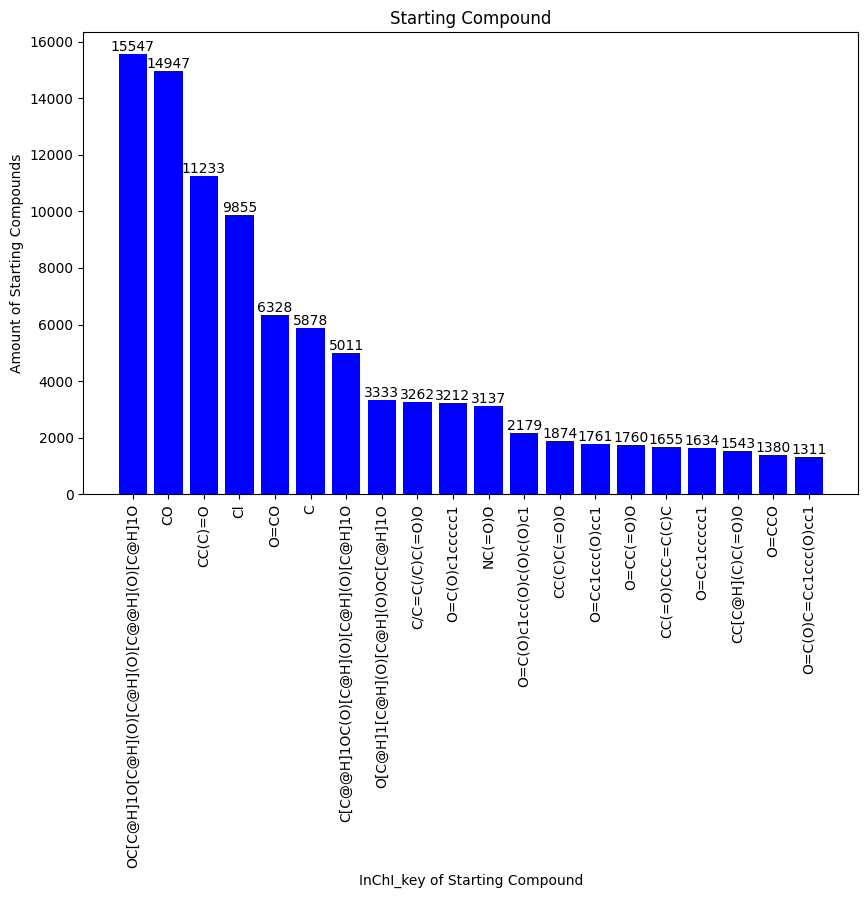

shape: (20, 2)
┌─────────────────────────────────┬───────┐
│ id                              ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ OC[C@H]1O[C@H](O)[C@H](O)[C@@H… ┆ 15547 │
│ CO                              ┆ 14947 │
│ CC(C)=O                         ┆ 11233 │
│ Cl                              ┆ 9855  │
│ O=CO                            ┆ 6328  │
│ …                               ┆ …     │
│ CC(=O)CCC=C(C)C                 ┆ 1655  │
│ O=Cc1ccccc1                     ┆ 1634  │
│ CC[C@H](C)C(=O)O                ┆ 1543  │
│ O=CCO                           ┆ 1380  │
│ O=C(O)C=Cc1ccc(O)cc1            ┆ 1311  │
└─────────────────────────────────┴───────┘


In [32]:
write_fig = True

# Filter data by type
starting_compounds = df_comp.filter(pl.col('type') == 'Starting Compound')

# Count the occurrences of starting compounds for each starting compound ID
starting_count = starting_compounds.group_by('id').count()
starting_count = starting_count.sort('count', descending=True)

#starting_count = replace_id(starting_count[0:20], replace_name="structure_nameTraditional" )
starting_count = replace_id(starting_count[0:20], replace_name="SMILES" )

# Add the numbers on top of each bar
plt.figure(figsize=(10, 6))
bars = plt.bar(starting_count['id'], starting_count['count'], color='blue')
plt.xlabel('InChI_key of Starting Compound')
plt.ylabel('Amount of Starting Compounds')
plt.title('Starting Compound')
plt.xticks(rotation=90)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%d' % int(height), ha='center', va='bottom')

# Save the figure if write_fig is True
if write_fig:
    plt.savefig('../data/starting_compounds_top_20_barplot.png')

plt.show()

print(starting_count)

/tmp/ipykernel_2664491/1180207238.py:6: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  predicted_count = predicted_compounds.group_by('id').count()


Found replace_name: Br for id: Cf832df7e99cab85f81bb00bc985412d7cf424409
Found replace_name: O=S(=O)(O)OO for id: Cbeafbb8f579e289f50a66a2be4f2bfc232c02d6f
Found replace_name: OC[C@@]1(O)CO[C@@H](O)[C@@H]1O for id: C8ae480eb6c254b8a90818fcaffb6c7d6c8b74139
Found replace_name: CC(C)(O)C=O for id: Ca3a0ad590f8aeb7045f5e92cf9f1d84377f98d15
Found replace_name: COC(=O)C=O for id: C84cb2f7e765ed6494b6650a2615fc08606587f8a
Found replace_name: CC(C)C for id: Cbb4e00526d0f100dd7a79df741588c6836094166
Found replace_name: C=C(C)C for id: C9ff2db8c112a1f93552bf1d2deef8310b8ca96b9
Found replace_name: CCCCC/C=C/CC=O for id: C226f0027de99ad0af9ba3423b1faacc62117cab0
Found replace_name: C[C@@H]1O[C@@H](O[C@H]2[C@@H](O)[C@@H](O)[C@H](O)O[C@@H]2CO)[C@H](O)[C@H](O)[C@H]1O for id: Cf76eabd9f5b274e726753ccdff946386006aff0c
Found replace_name: F for id: Cbe7d8c1f20311b2e2093befdee25a421c4c961e1
Found replace_name: CC(C)[C@@H](C)C=O for id: C65ee428fd4dd70b3764b1e3c36c414bd147b4678
Found replace_name: CC(=O)

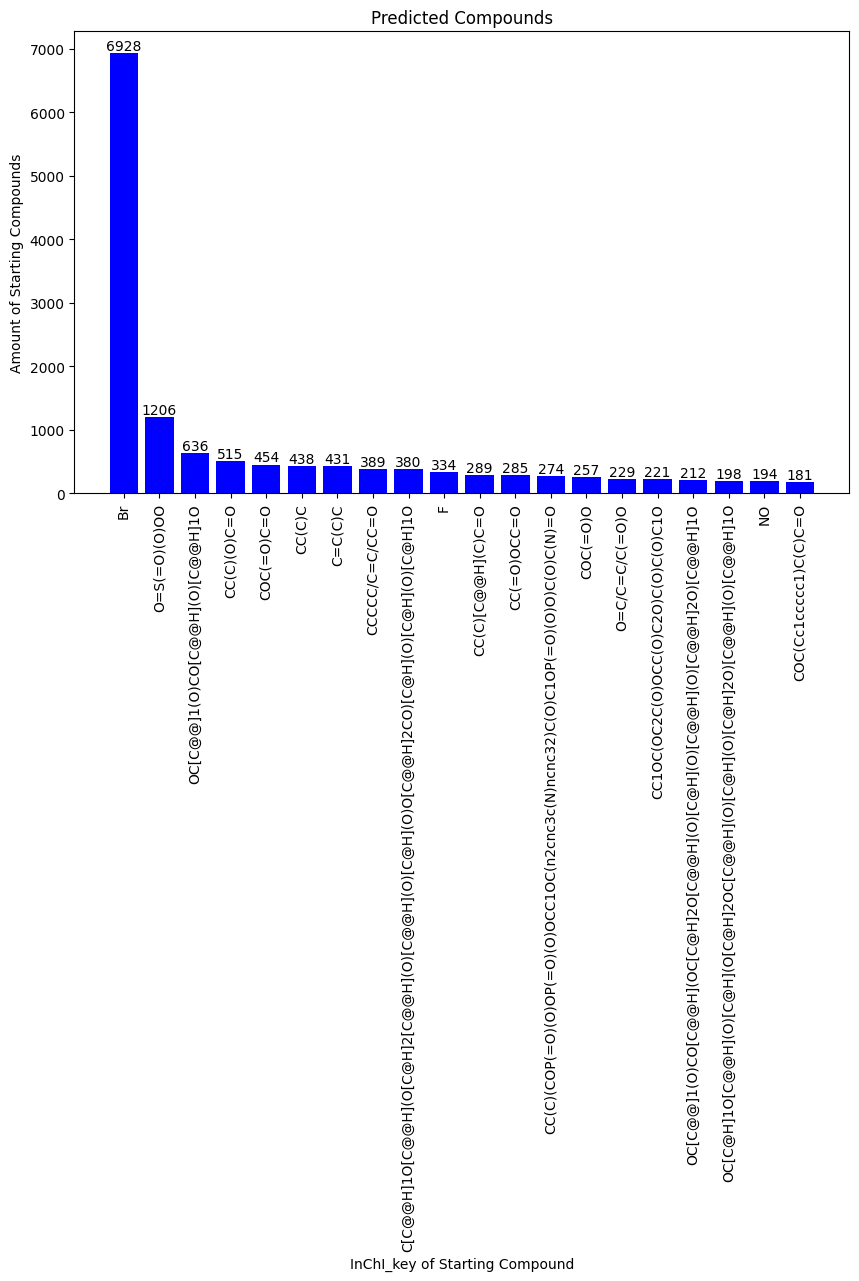

shape: (20, 2)
┌─────────────────────────────────┬───────┐
│ id                              ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ Br                              ┆ 6928  │
│ O=S(=O)(O)OO                    ┆ 1206  │
│ OC[C@@]1(O)CO[C@@H](O)[C@@H]1O  ┆ 636   │
│ CC(C)(O)C=O                     ┆ 515   │
│ COC(=O)C=O                      ┆ 454   │
│ …                               ┆ …     │
│ CC1OC(OC2C(O)OCC(O)C2O)C(O)C(O… ┆ 221   │
│ OC[C@@]1(O)CO[C@@H](OC[C@H]2O[… ┆ 212   │
│ OC[C@H]1O[C@@H](O)[C@H](O[C@H]… ┆ 198   │
│ NO                              ┆ 194   │
│ COC(Cc1ccccc1)C(C)C=O           ┆ 181   │
└─────────────────────────────────┴───────┘


In [33]:
write_fig = True

predicted_compounds = df_comp.filter(pl.col('type') == 'Predicted')

# Count the occurrences of predicted compounds for each starting compound ID
predicted_count = predicted_compounds.group_by('id').count()
predicted_count = predicted_count.sort('count', descending=True)

predicted_count = replace_id(predicted_count[0:20], replace_name="SMILES")

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(predicted_count['id'], predicted_count['count'], color='blue')
plt.xlabel('InChI_key of Starting Compound')
plt.ylabel('Amount of Starting Compounds')
plt.title('Predicted Compounds')
plt.xticks(rotation=90)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%d' % int(height), ha='center', va='bottom')

# Save the figure if write_fig is True
if write_fig:
    plt.savefig('../data/predicted_compounds_top_20_barplot.png')

plt.show()

print(predicted_count)

### starting and predicted compounds plots with real counts

In [7]:
%%time

df2 = pl.read_parquet("../data/MINES/reactions_compounds_list_with_counts.parquet")

# Explode reactants and products
reactants_exploded = df2.explode("reactants").select(pl.col(["reaction_id", "reactants"])).unnest("reactants").with_columns(pl.lit(True).alias('reactant'))
products_exploded = df2.explode("products").select(pl.col(["reaction_id", "products"])).unnest("products").with_columns(pl.lit(False).alias('reactant'))

df_comp2 = pl.concat([reactants_exploded, products_exploded], how="vertical")  

df_comp2

CPU times: user 13.6 s, sys: 11.6 s, total: 25.2 s
Wall time: 21.4 s


reaction_id,id,type,count,reactant
str,str,str,i64,bool
"""R5d8539f1d9a5e857189956bad8eb48e7b11137a25b12c2a7293fa1b61562e629""","""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919""","""Starting Compound""",2,true
"""R5d8539f1d9a5e857189956bad8eb48e7b11137a25b12c2a7293fa1b61562e629""","""X0eb45233dd43ecacb9fb1e31140450e1dace01c5""","""Coreactant""",1,true
"""R5d8539f1d9a5e857189956bad8eb48e7b11137a25b12c2a7293fa1b61562e629""","""X8dc023d8052d83fb6feadf8541387e57c199cad0""","""Coreactant""",1,true
"""R6a89aaf90529aa474f537c081d71ff584fa0179bdde8269c9ae4b80b2e5c96f7""","""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919""","""Starting Compound""",2,true
"""R6a89aaf90529aa474f537c081d71ff584fa0179bdde8269c9ae4b80b2e5c96f7""","""X0eb45233dd43ecacb9fb1e31140450e1dace01c5""","""Coreactant""",1,true
"""R6a89aaf90529aa474f537c081d71ff584fa0179bdde8269c9ae4b80b2e5c96f7""","""X8dc023d8052d83fb6feadf8541387e57c199cad0""","""Coreactant""",1,true
"""Rf0c39549766c89963dbb1a98f8f1d4b89431cf4ee60f962c7703ef9df5bcb327""","""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919""","""Starting Compound""",2,true
"""Rf0c39549766c89963dbb1a98f8f1d4b89431cf4ee60f962c7703ef9df5bcb327""","""X0eb45233dd43ecacb9fb1e31140450e1dace01c5""","""Coreactant""",1,true
"""Rf0c39549766c89963dbb1a98f8f1d4b89431cf4ee60f962c7703ef9df5bcb327""","""X8dc023d8052d83fb6feadf8541387e57c199cad0""","""Coreactant""",1,true


total counts over all: 4_592_044, only ones in the df: 362
Found replace_name: OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O for id: C9ab1a08d72c90a8167d1f3a668d8f1138e534a07
Found replace_name: CO for id: Cf32ec10ed591559703aa6d0857bdee249c4e1a4d
Found replace_name: CC(C)=O for id: Cf29ab8236bcc427a65d62b87ee3f7eb03d824537
Found replace_name: Cl for id: C33faa2b8ca452db82058619ed2de70883482f89d
Found replace_name: O=CO for id: C0e2c8d649fd28524ed617a741b4da1c714899166
Found replace_name: C for id: C3f8881998951e22f122db498b619af1eea58d2c1
Found replace_name: C[C@@H]1OC(O)[C@H](O)[C@H](O)[C@H]1O for id: C2b9dd22b6408975452f0865c4ee28ca5254a1adb
Found replace_name: O[C@H]1[C@H](O)[C@H](O)OC[C@H]1O for id: Ca2c5b2bda608fea82809b23867a03096c9d0715c
Found replace_name: C/C=C(/C)C(=O)O for id: C41d99a021c3e0437fb983fa328d642276b2d0f1b
Found replace_name: O=C(O)c1ccccc1 for id: Ce78e822bd39b86bbad3c1f7a4a256c00702cac00
Found replace_name: NC(=O)O for id: C1cff1e0363c01af7dfb5a374f635aecd4ce8e77f

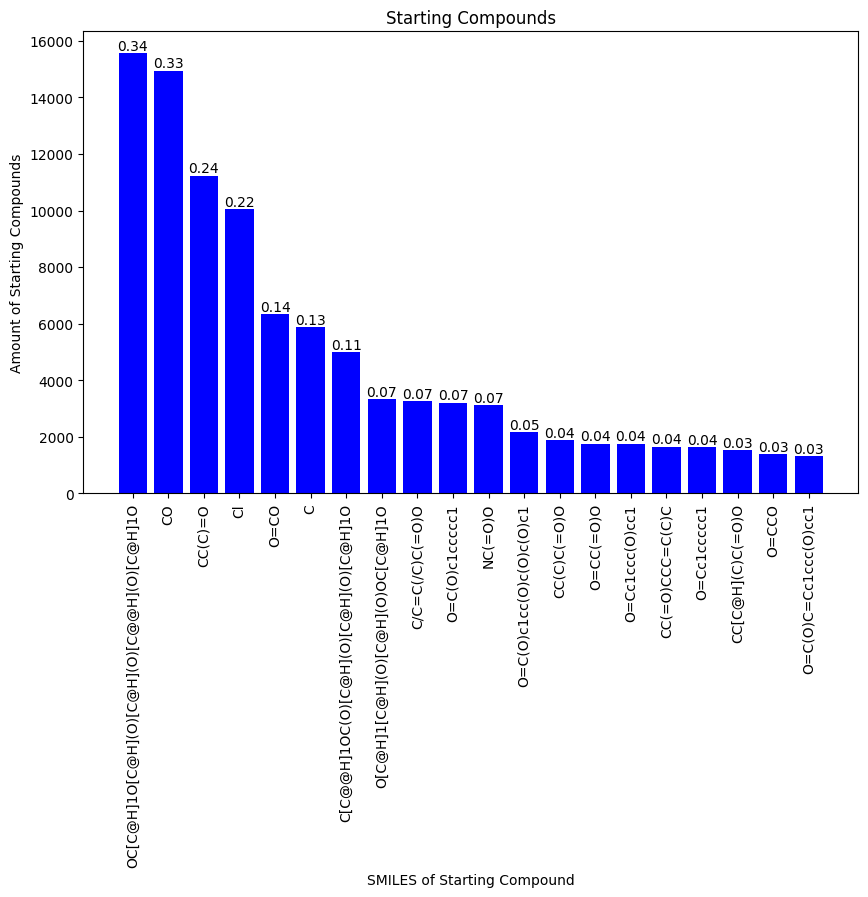

shape: (20, 2)
┌───────────────────────────────────────────┬───────┐
│ id                                        ┆ count │
│ ---                                       ┆ ---   │
│ str                                       ┆ i64   │
╞═══════════════════════════════════════════╪═══════╡
│ OC[C@H]1O[C@H](O)[C@H](O)[C@@H](O)[C@H]1O ┆ 15552 │
│ CO                                        ┆ 14947 │
│ CC(C)=O                                   ┆ 11234 │
│ Cl                                        ┆ 10060 │
│ O=CO                                      ┆ 6328  │
│ C                                         ┆ 5878  │
│ C[C@@H]1OC(O)[C@H](O)[C@H](O)[C@H]1O      ┆ 5012  │
│ O[C@H]1[C@H](O)[C@H](O)OC[C@H]1O          ┆ 3334  │
│ C/C=C(/C)C(=O)O                           ┆ 3262  │
│ O=C(O)c1ccccc1                            ┆ 3212  │
│ NC(=O)O                                   ┆ 3137  │
│ O=C(O)c1cc(O)c(O)c(O)c1                   ┆ 2182  │
│ CC(C)C(=O)O                               ┆ 1875  │
│ O=CC(=O)O  

In [7]:
write_fig = False

starting_compounds = df_comp2.filter(pl.col('type') == 'Starting Compound')

# Count the occurrences of predicted compounds for each starting compound ID
starting_counts = starting_compounds.group_by('id').agg(pl.col('count').sum())
starting_counts = starting_counts.sort('count', descending=True)
total_counts = starting_counts["count"].sum()

one_counter = starting_counts.filter(pl.col("count") == 1).shape[0]
print(f'total counts over all: {total_counts:_}, only ones in the df: {one_counter}')


starting_counts = replace_id(starting_counts[0:20], replace_name="SMILES")

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(starting_counts['id'], starting_counts['count'], color='blue')
plt.xlabel('SMILES of Starting Compound')
plt.ylabel('Amount of Starting Compounds')
plt.title('Starting Compounds')
plt.xticks(rotation=90)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%.2f' % float(height/total_counts*100), ha='center', va='bottom')

# Save the figure if write_fig is True
if write_fig:
    plt.savefig('../data/starting_compounds_top_20_barplot_counts.png')

plt.show()

print(starting_counts)

total counts over all: 3_456_181, only ones in the df: 3213470
Found replace_name: Br for id: Cf832df7e99cab85f81bb00bc985412d7cf424409
Found replace_name: O=S(=O)(O)OO for id: Cbeafbb8f579e289f50a66a2be4f2bfc232c02d6f
Found replace_name: OC[C@@]1(O)CO[C@@H](O)[C@@H]1O for id: C8ae480eb6c254b8a90818fcaffb6c7d6c8b74139
Found replace_name: CC(C)(O)C=O for id: Ca3a0ad590f8aeb7045f5e92cf9f1d84377f98d15
Found replace_name: COC(=O)C=O for id: C84cb2f7e765ed6494b6650a2615fc08606587f8a
Found replace_name: CC(C)C for id: Cbb4e00526d0f100dd7a79df741588c6836094166
Found replace_name: C=C(C)C for id: C9ff2db8c112a1f93552bf1d2deef8310b8ca96b9
Found replace_name: CCCCC/C=C/CC=O for id: C226f0027de99ad0af9ba3423b1faacc62117cab0
Found replace_name: C[C@@H]1O[C@@H](O[C@H]2[C@@H](O)[C@@H](O)[C@H](O)O[C@@H]2CO)[C@H](O)[C@H](O)[C@H]1O for id: Cf76eabd9f5b274e726753ccdff946386006aff0c
Found replace_name: F for id: Cbe7d8c1f20311b2e2093befdee25a421c4c961e1
Found replace_name: CC(C)[C@@H](C)C=O for id: C65ee

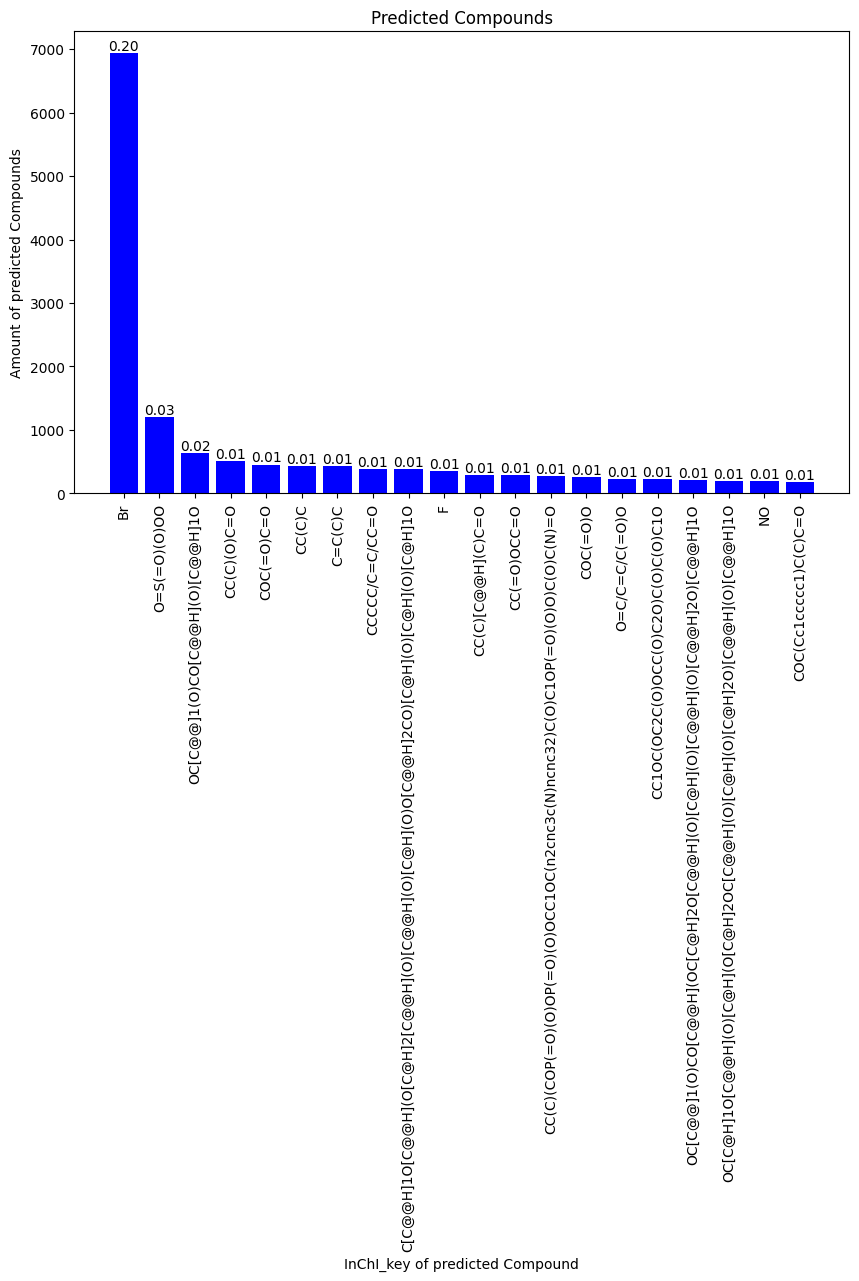

shape: (20, 2)
┌─────────────────────────────────────────────────────────────────────────────────────┬───────┐
│ id                                                                                  ┆ count │
│ ---                                                                                 ┆ ---   │
│ str                                                                                 ┆ i64   │
╞═════════════════════════════════════════════════════════════════════════════════════╪═══════╡
│ Br                                                                                  ┆ 6931  │
│ O=S(=O)(O)OO                                                                        ┆ 1206  │
│ OC[C@@]1(O)CO[C@@H](O)[C@@H]1O                                                      ┆ 636   │
│ CC(C)(O)C=O                                                                         ┆ 515   │
│ COC(=O)C=O                                                                          ┆ 455   │
│ CC(C)C                 

In [4]:
write_fig = False

predicted_compounds = df_comp2.filter(pl.col('type') == 'Predicted')

# Count the occurrences of predicted compounds for each starting compound ID
predicted_count = predicted_compounds.group_by('id').agg(pl.col('count').sum())
predicted_count = predicted_count.sort('count', descending=True)
total_counts = predicted_count["count"].sum()

one_counter = predicted_count.filter(pl.col("count") == 1).shape[0]
print(f'total counts over all: {total_counts:_}, only ones in the df: {one_counter}')


predicted_count = replace_id(predicted_count[0:20], replace_name="SMILES")

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(predicted_count['id'], predicted_count['count'], color='blue')
plt.xlabel('InChI_key of predicted Compound')
plt.ylabel('Amount of predicted Compounds')
plt.title('Predicted Compounds')
plt.xticks(rotation=90)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%.2f' % float(height/total_counts*100), ha='center', va='bottom')

# Save the figure if write_fig is True
if write_fig:
    plt.savefig('../data/predicted_compounds_top_20_barplot_counts.png')

plt.show()

print(predicted_count)

### reactions

In [5]:
df_comp2

reaction_id,id,type,count,reactant
str,str,str,i64,bool
"""R5d8539f1d9a5e857189956bad8eb48e7b11137a25b12c2a7293fa1b61562e629""","""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919""","""Starting Compound""",2,true
"""R5d8539f1d9a5e857189956bad8eb48e7b11137a25b12c2a7293fa1b61562e629""","""X0eb45233dd43ecacb9fb1e31140450e1dace01c5""","""Coreactant""",1,true
"""R5d8539f1d9a5e857189956bad8eb48e7b11137a25b12c2a7293fa1b61562e629""","""X8dc023d8052d83fb6feadf8541387e57c199cad0""","""Coreactant""",1,true
"""R6a89aaf90529aa474f537c081d71ff584fa0179bdde8269c9ae4b80b2e5c96f7""","""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919""","""Starting Compound""",2,true
"""R6a89aaf90529aa474f537c081d71ff584fa0179bdde8269c9ae4b80b2e5c96f7""","""X0eb45233dd43ecacb9fb1e31140450e1dace01c5""","""Coreactant""",1,true
"""R6a89aaf90529aa474f537c081d71ff584fa0179bdde8269c9ae4b80b2e5c96f7""","""X8dc023d8052d83fb6feadf8541387e57c199cad0""","""Coreactant""",1,true
"""Rf0c39549766c89963dbb1a98f8f1d4b89431cf4ee60f962c7703ef9df5bcb327""","""Ce8bc5cd3aa30776ab6d35fdc2bcc4707f4ac2919""","""Starting Compound""",2,true
"""Rf0c39549766c89963dbb1a98f8f1d4b89431cf4ee60f962c7703ef9df5bcb327""","""X0eb45233dd43ecacb9fb1e31140450e1dace01c5""","""Coreactant""",1,true
"""Rf0c39549766c89963dbb1a98f8f1d4b89431cf4ee60f962c7703ef9df5bcb327""","""X8dc023d8052d83fb6feadf8541387e57c199cad0""","""Coreactant""",1,true


In [19]:
write_fig = False

# Count the occurrences of predicted compounds for each starting compound ID
reaction_count = df_comp2["reaction_id"].unique()

print(f'total reactions: {reaction_count.shape[0]:_}')

total reactions: 3_435_078


### Bor - why is it so many times in the predicted...
first we try to get all reactions with Bor (Br).
After that we like to have all compounds in this reactions.
After that, we will again at the abudance plot.

total counts over all: 28_341, only ones in the df: 7386
Found replace_name: Br for id: Cf832df7e99cab85f81bb00bc985412d7cf424409
Found replace_name: O for id: X73bc8ef21db580aefe4dbc0af17d4013961d9d17
Found replace_name: [H+] for id: X0eb45233dd43ecacb9fb1e31140450e1dace01c5
Found replace_name: C[C@](Br)(CBr)[C@@H]1CC[C@](C)(Br)[C@@H](Br)C1 for id: C8b84ea4ca7e00b0b51d18b24deab7a119b69291b
Found replace_name: COC1=C(Br)[C@@H](O)[C@]2(C=C1Br)CC(C(=O)NCCCOc1c(Br)cc(CC(NC(=O)C(Cc3cc(Br)c(OCCCNC(=O)C4=NO[C@@]5(C=C(Br)C(OC)=C(Br)[C@H]5O)C4)c(Br)c3)NS(=O)(=O)O)C(=O)O)cc1Br)=NO2 for id: C64314d85e609e7120e1f444a9978d897a65ac312
Found replace_name: COC1=C(Br)[C@H](O)[C@@]2(C=C1Br)CC(C(=O)NCCCOc1c(Br)cc([C@@H](O)CNC(=O)C3=NO[C@]4(C=C(Br)C(OC)=C(Br)[C@@H]4O)C3)cc1Br)=NO2 for id: C916ca863324e7442fe6a63869ce2bebe53757817
Found replace_name: COC1=C(Br)[C@@H](O)[C@]2(C=C1Br)CC(C(=O)NC[C@H](O)c1cc(Br)c(OC[C@@H](O)CNC(=O)C3=NO[C@]4(C=C(Br)C(OC)=C(Br)[C@@H]4O)C3)c(Br)c1)=NO2 for id: C324c15d85addd0d3

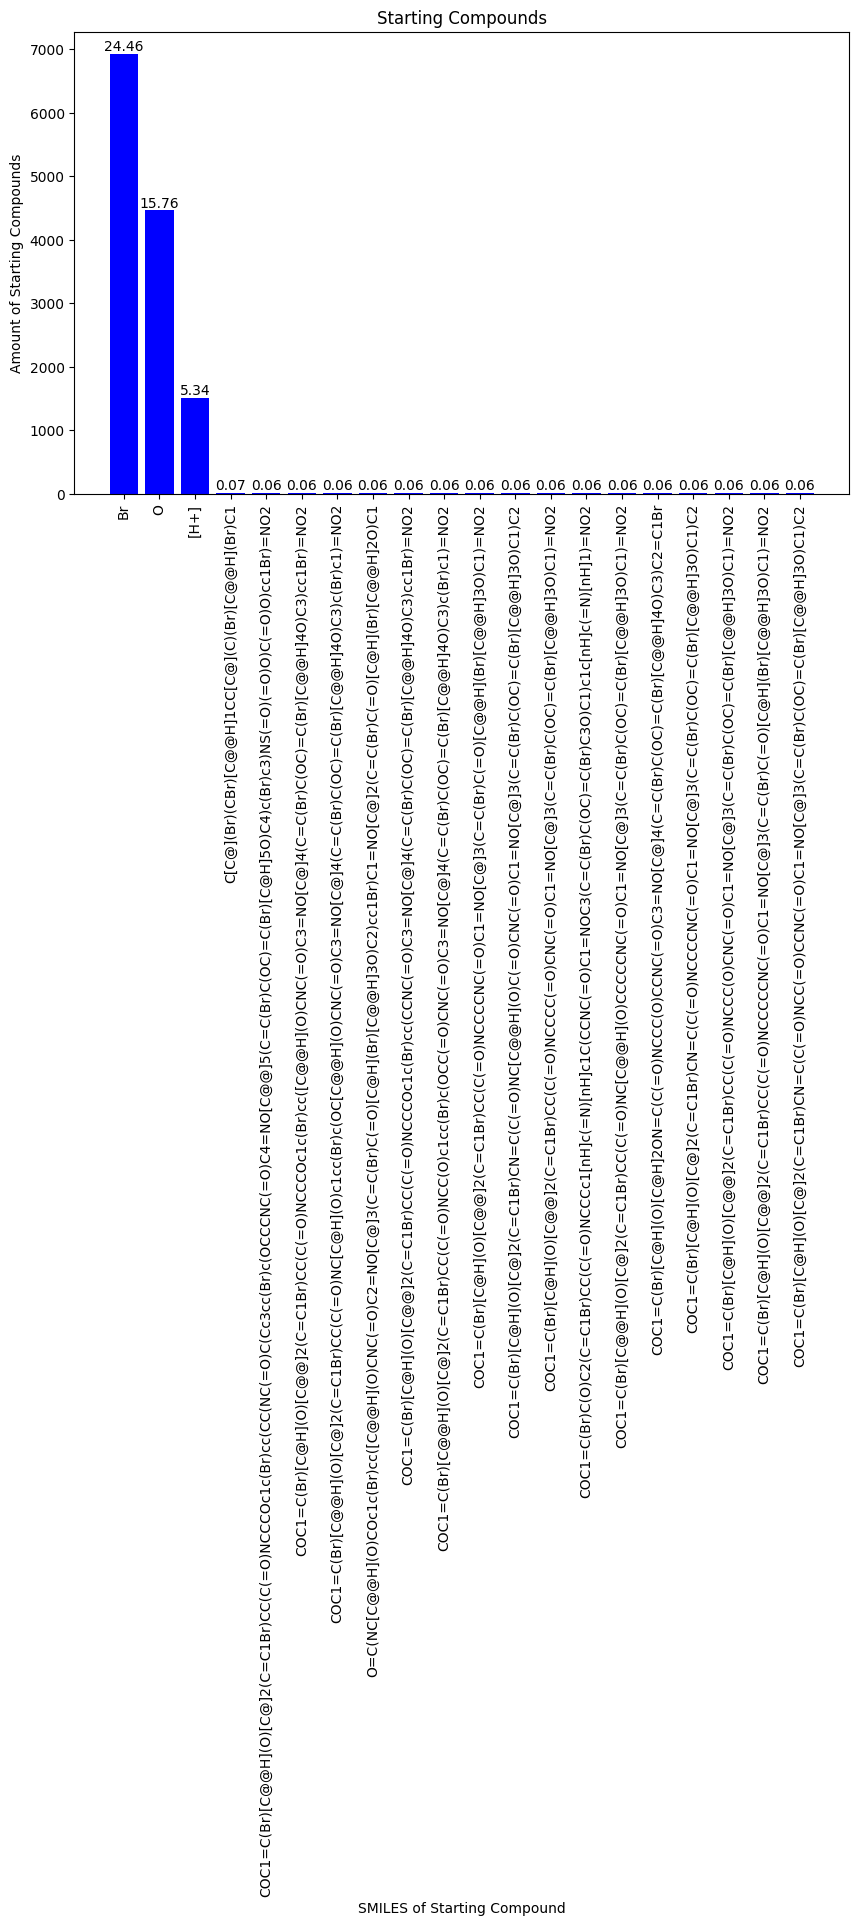

shape: (20, 2)
┌──────────────────────────────────────────────────────────────────────────────────────────┬───────┐
│ id                                                                                       ┆ count │
│ ---                                                                                      ┆ ---   │
│ str                                                                                      ┆ i64   │
╞══════════════════════════════════════════════════════════════════════════════════════════╪═══════╡
│ Br                                                                                       ┆ 6931  │
│ O                                                                                        ┆ 4467  │
│ [H+]                                                                                     ┆ 1513  │
│ C[C@](Br)(CBr)[C@@H]1CC[C@](C)(Br)[C@@H](Br)C1                                           ┆ 19    │
│ COC1=C(Br)[C@@H](O)[C@]2(C=C1Br)CC(C(=O)NCCCOc1c(Br)cc(CC(NC(=O)C(Cc3cc(Br

In [17]:
reactions_bor = df_comp2.filter(pl.col("id") == "Cf832df7e99cab85f81bb00bc985412d7cf424409")['reaction_id']

reactions_bor_compounds = df_comp2.filter(pl.col("reaction_id").is_in(reactions_bor))

write_fig = False

# Count the occurrences of predicted compounds for each starting compound ID
starting_counts = reactions_bor_compounds.group_by('id').agg(pl.col('count').sum())
starting_counts = starting_counts.sort('count', descending=True)
total_counts = starting_counts["count"].sum()

one_counter = starting_counts.filter(pl.col("count") == 1).shape[0]
print(f'total counts over all: {total_counts:_}, only ones in the df: {one_counter}')


starting_counts = replace_id(starting_counts[0:20], replace_name="SMILES")

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(starting_counts['id'], starting_counts['count'], color='blue')
plt.xlabel('SMILES of Starting Compound')
plt.ylabel('Amount of Starting Compounds')
plt.title('Starting Compounds')
plt.xticks(rotation=90)

# Add text labels on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             '%.2f' % float(height/total_counts*100), ha='center', va='bottom')

# Save the figure if write_fig is True
if write_fig:
    plt.savefig('../data/starting_compounds_top_20_barplot_counts.png')

plt.show()

print(starting_counts)